Check Environment

In [2]:
import torch
print(torch.cuda.is_available())
print(torch.cuda.get_device_name(0))
import os
os.environ["WANDB_MODE"] = "disabled"
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

# Create a new directory
os.makedirs('models')
os.makedirs('final_models')


True
NVIDIA L4
Mounted at /content/drive


Transfer Learning Stage

In [12]:
# Import necessary libraries
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import torch
from transformers import BertTokenizer, BertForSequenceClassification, Trainer, TrainingArguments
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import pickle
# Load datasets
labels_df = pd.read_csv("/content/drive/MyDrive/mbti-dataset/mbti_labels.csv")
tweets_df = pd.read_csv("/content/drive/MyDrive/mbti-dataset/user_tweets_concatenated.csv")
user_df = pd.read_csv("/content/drive/MyDrive/mbti-dataset/sorted_user_info_preprocessed.csv")

# Merge datasets
data = pd.merge(labels_df, tweets_df, on="id")
data = pd.merge(data, user_df, on="id")

# Combine merged_tweets and description
# data['combined_texts'] = data['description'].fillna('') + " " + data['merged_tweets'].fillna('')
# Simple concatenation affects the contexts continuity in the start of the long sequence and it is not good for BERT.
# Instead, we choose to insert the description into somewhere deeper in the merged tweets and treat it like one of the tweets.
n = 80
data['combined_texts'] = data.apply(
    lambda row: str(row['merged_tweets'])[:n] + str(row['description']) + str(row['merged_tweets'])[n:] if pd.notnull(row['merged_tweets']) else str(row['description']),
    axis=1
)
# Reset index to avoid KeyError during row access
data.reset_index(drop=True, inplace=True)
print("Data index:", data.index)
print("Data columns:", data.columns)
# Generate binary labels for each dimension
data['t_f_label'] = data['mbti_personality'].apply(lambda x: 't' if 't' in x[2].lower() else 'f')
data['e_i_label'] = data['mbti_personality'].apply(lambda x: 'e' if 'e' in x[0].lower() else 'i')
data['n_s_label'] = data['mbti_personality'].apply(lambda x: 'n' if 'n' in x[1].lower() else 's')
data['j_p_label'] = data['mbti_personality'].apply(lambda x: 'j' if 'j' in x[3].lower() else 'p')

# Verify label creation
print("Sample labels:")
print(data[['t_f_label', 'e_i_label', 'n_s_label', 'j_p_label']].head())

# Encode labels
label_encoder = LabelEncoder()
data['t_f_label'] = label_encoder.fit_transform(data['t_f_label'])
data['e_i_label'] = label_encoder.fit_transform(data['e_i_label'])
data['n_s_label'] = label_encoder.fit_transform(data['n_s_label'])
data['j_p_label'] = label_encoder.fit_transform(data['j_p_label'])
print("Encoded labels:")
print(data[['t_f_label', 'e_i_label', 'n_s_label', 'j_p_label']].head())

# Function to train BERT for a given label
def train_bert_for_label(data, label_column, output_dir):
    # Split dataset
    if label_column not in data.columns:
        raise KeyError(f"Column {label_column} does not exist in DataFrame.")

    # Check for null values
    print(f"Null values in {label_column}: {data[label_column].isnull().sum()}")
    print(f"Null values in combined_texts: {data['combined_texts'].isnull().sum()}")

    train_texts, val_texts, train_labels, val_labels = train_test_split(
        data['combined_texts'].tolist(),
        data[label_column].tolist(),
        test_size=0.2,
        random_state=42
    )
    # Debugging: Check train-test split
    print(f"Number of training samples: {len(train_texts)}")
    print(f"Number of validation samples: {len(val_texts)}")

    # Tokenize texts
    tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
    train_encodings = tokenizer(train_texts, truncation=True, padding=True, max_length=128)
    val_encodings = tokenizer(val_texts, truncation=True, padding=True, max_length=128)

    # Dataset class
    class MBTIDataset(torch.utils.data.Dataset):
        def __init__(self, encodings, labels):
            self.encodings = encodings
            self.labels = labels

        def __getitem__(self, idx):
            item = {key: val[idx] for key, val in self.encodings.items()}
            item['labels'] = torch.tensor(self.labels[idx])
            return item

        def __len__(self):
            return len(self.labels)

    # Create datasets
    train_dataset = MBTIDataset(train_encodings, train_labels)
    val_dataset = MBTIDataset(val_encodings, val_labels)

    # Load pre-trained BERT model
    model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=2)

    # Define evaluation metrics
    def compute_metrics(pred):
        logits, labels = pred
        predictions = logits.argmax(axis=-1)
        accuracy = accuracy_score(labels, predictions)
        precision = precision_score(labels, predictions, average='binary')
        recall = recall_score(labels, predictions, average='binary')
        f1 = f1_score(labels, predictions, average='binary')
        return {'accuracy': accuracy, 'precision': precision, 'recall': recall, 'f1': f1}

    # Set training arguments
    training_args = TrainingArguments(
        output_dir=output_dir,
        num_train_epochs=3,
        per_device_train_batch_size=16,
        per_device_eval_batch_size=16,
        warmup_steps=500,
        weight_decay=0.01,
        logging_dir='./logs',
        logging_steps=10,
        eval_strategy="epoch",
        save_strategy="epoch",
        report_to="none",
        load_best_model_at_end=True,
    )

    # Initialize Trainer
    trainer = Trainer(
        model=model,
        args=training_args,
        train_dataset=train_dataset,
        eval_dataset=val_dataset,
        compute_metrics=compute_metrics,
    )

    # Train the model
    trainer.train()

    # Evaluate the model
    eval_results = trainer.evaluate()
    print(f"Results for {label_column}: {eval_results}")

    return model, label_encoder

# Train BERT models for all binary labels
bert_models = {}
label_encoders = {}
for label, column in zip(['T-F', 'E-I', 'N-S', 'J-P'], ['t_f_label', 'e_i_label', 'n_s_label', 'j_p_label']):
    print(f"Training for {label}...")
    bert_models[label], label_encoders[label] = train_bert_for_label(data, column, f"./results_{label}")
    # Save the model and label encoder
    model_save_path = f"/content/models/bert_{label}.pt"
    label_encoder_save_path = f"/content/models/label_encoder_{label}.pkl"
    torch.save(bert_models[label].state_dict(), model_save_path)
    with open(label_encoder_save_path, 'wb') as f:
        pickle.dump(label_encoders[label], f)
    print(f"Saved {label} model to {model_save_path} and label encoder to {label_encoder_save_path}")


Data index: RangeIndex(start=0, stop=6011, step=1)
Data columns: Index(['id', 'mbti_personality', 'merged_tweets', 'screen_name', 'description',
       'followers_count', 'friends_count', 'listed_count', 'favourites_count',
       'statuses_count', 'number_of_quoted_statuses',
       'number_of_retweeted_statuses', 'average_tweet_length',
       'average_retweet_count', 'average_favorite_count',
       'average_hashtag_count', 'average_url_count', 'average_mentions_count',
       'average_media_count', 'verified_True', 'combined_texts'],
      dtype='object')
Sample labels:
  t_f_label e_i_label n_s_label j_p_label
0         f         i         n         p
1         f         i         n         p
2         f         i         n         p
3         f         i         n         p
4         f         i         n         p
Encoded labels:
   t_f_label  e_i_label  n_s_label  j_p_label
0          0          1          0          1
1          0          1          0          1
2          0 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,0.202600,0.168397,0.920200,0.855754,0.986916,0.916667
2,0.092500,0.149975,0.938487,0.934087,0.927103,0.930582
3,0.147600,0.194350,0.936825,0.925788,0.932710,0.929236


Results for t_f_label: {'eval_loss': 0.1499754935503006, 'eval_accuracy': 0.9384871155444722, 'eval_precision': 0.9340866290018832, 'eval_recall': 0.9271028037383178, 'eval_f1': 0.9305816135084428, 'eval_runtime': 4.0177, 'eval_samples_per_second': 299.425, 'eval_steps_per_second': 18.916, 'epoch': 3.0}
Saved T-F model to /content/models/bert_T-F.pt and label encoder to /content/models/label_encoder_T-F.pkl
Training for E-I...
Null values in e_i_label: 0
Null values in combined_texts: 0
Number of training samples: 4808
Number of validation samples: 1203


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,0.381500,0.311379,0.857855,0.827225,0.941878,0.880836
2,0.189400,0.173972,0.913549,0.889959,0.964232,0.925608
3,0.135500,0.184619,0.923525,0.932735,0.929955,0.931343


Results for e_i_label: {'eval_loss': 0.17397163808345795, 'eval_accuracy': 0.913549459684123, 'eval_precision': 0.889958734525447, 'eval_recall': 0.9642324888226528, 'eval_f1': 0.9256080114449213, 'eval_runtime': 4.068, 'eval_samples_per_second': 295.721, 'eval_steps_per_second': 18.682, 'epoch': 3.0}
Saved E-I model to /content/models/bert_E-I.pt and label encoder to /content/models/label_encoder_E-I.pkl
Training for N-S...
Null values in n_s_label: 0
Null values in combined_texts: 0
Number of training samples: 4808
Number of validation samples: 1203


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,0.506200,0.404686,0.853699,0.750000,0.576923,0.652174
2,0.079700,0.161309,0.951787,0.885135,0.916084,0.900344
3,0.078300,0.147840,0.957606,0.915194,0.905594,0.910369


Results for n_s_label: {'eval_loss': 0.14784026145935059, 'eval_accuracy': 0.9576059850374065, 'eval_precision': 0.9151943462897526, 'eval_recall': 0.9055944055944056, 'eval_f1': 0.9103690685413005, 'eval_runtime': 4.1041, 'eval_samples_per_second': 293.124, 'eval_steps_per_second': 18.518, 'epoch': 3.0}
Saved N-S model to /content/models/bert_N-S.pt and label encoder to /content/models/label_encoder_N-S.pkl
Training for J-P...
Null values in j_p_label: 0
Null values in combined_texts: 0
Number of training samples: 4808
Number of validation samples: 1203


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,0.173400,0.263438,0.903574,0.940613,0.852431,0.894353
2,0.141500,0.153029,0.921031,0.946197,0.885417,0.914798
3,0.155500,0.160602,0.934331,0.927711,0.935764,0.931720


Results for j_p_label: {'eval_loss': 0.15302875638008118, 'eval_accuracy': 0.9210307564422278, 'eval_precision': 0.9461966604823747, 'eval_recall': 0.8854166666666666, 'eval_f1': 0.9147982062780269, 'eval_runtime': 4.086, 'eval_samples_per_second': 294.424, 'eval_steps_per_second': 18.6, 'epoch': 3.0}
Saved J-P model to /content/models/bert_J-P.pt and label encoder to /content/models/label_encoder_J-P.pkl


Multimodal Learning Stage

In [15]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

# Import necessary libraries
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import torch
from transformers import BertTokenizer, BertForSequenceClassification
from torchvision import models, transforms
from PIL import Image
from torch import nn
import os
from tqdm import tqdm
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Load datasets
labels_df = pd.read_csv("/content/drive/MyDrive/mbti-dataset/mbti_labels.csv")
tweets_df = pd.read_csv("/content/drive/MyDrive/mbti-dataset/user_tweets_concatenated.csv")
user_df = pd.read_csv("/content/drive/MyDrive/mbti-dataset/sorted_user_info_preprocessed.csv")

# Merge datasets
data = pd.merge(labels_df, tweets_df, on="id")
data = pd.merge(data, user_df, on="id")

# Combine merged_tweets and description
# data['combined_texts'] = data['description'].fillna('') + " " + data['merged_tweets'].fillna('')
n = 30
data['combined_texts'] = data.apply(
    lambda row: str(row['merged_tweets'])[:n] + str(row['description']) + str(row['merged_tweets'])[n:] if pd.notnull(row['merged_tweets']) else str(row['description']),
    axis=1
)
# Reset index to avoid KeyError during row access
data.reset_index(drop=True, inplace=True)

# Generate binary labels for each dimension
data['t_f_label'] = data['mbti_personality'].apply(lambda x: 't' if 't' in x[2].lower() else 'f')
data['e_i_label'] = data['mbti_personality'].apply(lambda x: 'e' if 'e' in x[0].lower() else 'i')
data['n_s_label'] = data['mbti_personality'].apply(lambda x: 'n' if 'n' in x[1].lower() else 's')
data['j_p_label'] = data['mbti_personality'].apply(lambda x: 'j' if 'j' in x[3].lower() else 'p')

# Encode labels
label_encoder = LabelEncoder()
data['t_f_label'] = label_encoder.fit_transform(data['t_f_label'])
data['e_i_label'] = label_encoder.fit_transform(data['e_i_label'])
data['n_s_label'] = label_encoder.fit_transform(data['n_s_label'])
data['j_p_label'] = label_encoder.fit_transform(data['j_p_label'])

# Image preprocessing
image_folder = "/content/drive/MyDrive/mbti-dataset/avatar"
image_size = (128, 128)
transform = transforms.Compose([
    transforms.Resize(image_size),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

# Normalize numerical features
numerical_features = [
    'followers_count', 'friends_count','listed_count','favourites_count', 'statuses_count','number_of_quoted_statuses', 'average_tweet_length',
    'average_retweet_count', 'average_favorite_count', 'verified_True'
]
data[numerical_features] = data[numerical_features].fillna(0)  # Replace NaN with 0
data[numerical_features] = (data[numerical_features] - data[numerical_features].mean()) / data[numerical_features].std()

# Combined dataset class
class MultiModalDataset(torch.utils.data.Dataset):
    def __init__(self, text_encodings, labels, numerical_data, screen_names, image_folder, transform):
        self.text_encodings = text_encodings
        self.labels = labels
        self.numerical_data = numerical_data
        self.screen_names = screen_names
        self.image_folder = image_folder
        self.transform = transform

    def __getitem__(self, idx):
        if idx >= len(self.labels):
            raise IndexError(f"Index {idx} is out of bounds for dataset with length {len(self.labels)}")

        # Load text features
        item = {key: val[idx] for key, val in self.text_encodings.items()}

        # Debugging: Check text keys
        if not all(k in item for k in ['input_ids', 'attention_mask']):
            raise KeyError(f"Missing keys in text_encodings at index {idx}: {item.keys()}")

        # Load label
        item['labels'] = torch.tensor(self.labels[idx])

        # Load numerical features
        item['numerical'] = torch.tensor(self.numerical_data.iloc[idx], dtype=torch.float32)

        # Dynamically load image
        screen_name = self.screen_names.iloc[idx]
        image_path = os.path.join(self.image_folder, f"{screen_name}.jpg")
        if os.path.exists(image_path):
            image = Image.open(image_path).convert("RGB")
            item['image'] = self.transform(image)
        else:
            # Placeholder for missing images
            item['image'] = torch.zeros(3, *image_size)

        return item

    def __len__(self):
        return len(self.labels)

# Multi-modal model
class MultiModalModel(nn.Module):
    def __init__(self, text_model, num_numerical_features, image_model_name='resnet18'):
        super(MultiModalModel, self).__init__()
        # Pre-trained BERT model for text
        self.text_model = text_model
        # Image model
        self.image_model = models.resnet18(pretrained=True)
        self.image_model.fc = nn.Linear(self.image_model.fc.in_features, 128)
        # Numerical features model
        self.num_fc = nn.Sequential(nn.Linear(num_numerical_features, 64), nn.ReLU(), nn.Linear(64, 128))
        # Final classifier
        self.classifier = nn.Sequential(nn.Linear(768+128+128, 128), nn.ReLU(), nn.Linear(128, 2))

    def forward(self, text_inputs, numerical, image):
        # Text branch: Use the last hidden state from the text model
        outputs = self.text_model(**text_inputs, output_hidden_states=True, return_dict=True)
        last_hidden_state = outputs.hidden_states[-1]  # Shape: (batch_size, sequence_length, hidden_size)
        cls_token_embedding = last_hidden_state[:, 0, :]  # Extract [CLS] token embedding, shape: (batch_size, hidden_size)

        # Image branch
        image_out = self.image_model(image)

        # Numerical branch
        numerical_out = self.num_fc(numerical)

        # Concatenate all features and classify
        combined = torch.cat([cls_token_embedding, image_out, numerical_out], dim=1)
        return self.classifier(combined)

# Train multi-modal model
def train_multimodal_model(data, label_column, pretrained_text_model_path, output_dir):
    # Prepare data
    train_data, val_data = train_test_split(data, test_size=0.2, random_state=42)

    # Load the specific pre-trained BERT model for this label
    text_model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=2)
    text_model.load_state_dict(torch.load(pretrained_text_model_path))

    tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
    train_encodings = tokenizer(train_data['combined_texts'].tolist(), truncation=True, padding=True, max_length=128, return_tensors="pt")
    val_encodings = tokenizer(val_data['combined_texts'].tolist(), truncation=True, padding=True, max_length=128, return_tensors="pt")

    train_dataset = MultiModalDataset(
        text_encodings=train_encodings,
        labels=train_data[label_column].tolist(),
        numerical_data=train_data[numerical_features],
        screen_names=train_data['screen_name'],
        image_folder=image_folder,
        transform=transform
    )
    val_dataset = MultiModalDataset(
        text_encodings=val_encodings,
        labels=val_data[label_column].tolist(),
        numerical_data=val_data[numerical_features],
        screen_names=val_data['screen_name'],
        image_folder=image_folder,
        transform=transform
    )

    # Initialize multi-modal model with the specific text model
    model = MultiModalModel(
        text_model=text_model,
        num_numerical_features=len(numerical_features)
    )
    device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
    print(f"Using device: {device}")
    model.to(device)

    # Training setup
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

    # DataLoader
    train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=4)
    val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=32, num_workers=4)

    # Training loop
    for epoch in range(2):
        model.train()
        epoch_loss = 0
        for batch in tqdm(train_loader, desc=f"Epoch {epoch + 1} Training"):
            optimizer.zero_grad()

            # Prepare inputs
            text_inputs = {
                "input_ids": batch['input_ids'].to(device),
                "attention_mask": batch['attention_mask'].to(device)
            }
            numerical = batch['numerical'].to(device)
            image = batch['image'].to(device)
            labels = batch['labels'].to(device)

            # Forward pass
            outputs = model(text_inputs, numerical, image)
            loss = criterion(outputs, labels)
            epoch_loss += loss.item()

            # Backward pass
            loss.backward()
            optimizer.step()

        print(f"Epoch {epoch + 1} Loss: {epoch_loss:.4f}")

    # Evaluation
    model.eval()
    correct = 0
    total = 0
    all_labels = []
    all_predictions = []

    with torch.no_grad():
        for batch in tqdm(val_loader, desc="Validating"):
            text_inputs = {
                "input_ids": batch['input_ids'].to(device),
                "attention_mask": batch['attention_mask'].to(device)
            }
            numerical = batch['numerical'].to(device)
            image = batch['image'].to(device)
            labels = batch['labels'].to(device)

            outputs = model(text_inputs, numerical, image)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            all_predictions.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    accuracy = accuracy_score(all_labels, all_predictions)
    precision = precision_score(all_labels, all_predictions, average='binary')
    recall = recall_score(all_labels, all_predictions, average='binary')
    f1 = f1_score(all_labels, all_predictions, average='binary')
    print(f"Validation Accuracy: {100 * correct / total:.2f}%")
    print(f"Validation Accuracy: {accuracy:.2f}")
    print(f"Validation Precision: {precision:.2f}")
    print(f"Validation Recall: {recall:.2f}")
    print(f"Validation F1-score: {f1:.2f}")
    return model


# Train multi-modal models for all labels
for label, column in zip(['T-F', 'E-I', 'N-S', 'J-P'], ['t_f_label', 'e_i_label', 'n_s_label', 'j_p_label']):
    print(f"Training multi-modal model for {label}...")

    # Path to the pre-trained text model for the current label
    pretrained_text_model_path = f"/content/models/bert_{label}.pt"

    # Train the multi-modal model for the current label
    trained_model = train_multimodal_model(
        data=data,
        label_column=column,
        pretrained_text_model_path=pretrained_text_model_path,
        output_dir=f"./results_multimodal_{label}"
    )

    # # Save the trained multi-modal model
    multimodal_model_save_path = f"/content/final_models/multimodal_{label}.pt"
    torch.save(trained_model.state_dict(), multimodal_model_save_path)
    print(f"Saved multi-modal model for {label} to {multimodal_model_save_path}")


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Training multi-modal model for T-F...


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
<ipython-input-15-089062bc4d2e>:146: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We re

Using device: cuda


Epoch 1 Training:   0%|          | 0/151 [00:00<?, ?it/s]<ipython-input-15-089062bc4d2e>:92: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  item['numerical'] = torch.tensor(self.numerical_data.iloc[idx], dtype=torch.float32)
<ipython-input-15-089062bc4d2e>:92: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  item['numerical'] = torch.tensor(self.numerical_data.iloc[idx], dtype=torch.float32)
<ipython-input-15-089062bc4d2e>:92: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a valu

Epoch 1 Loss: 22.4983


Epoch 2 Training:   0%|          | 0/151 [00:00<?, ?it/s]<ipython-input-15-089062bc4d2e>:92: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  item['numerical'] = torch.tensor(self.numerical_data.iloc[idx], dtype=torch.float32)
<ipython-input-15-089062bc4d2e>:92: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  item['numerical'] = torch.tensor(self.numerical_data.iloc[idx], dtype=torch.float32)
<ipython-input-15-089062bc4d2e>:92: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a valu

Epoch 2 Loss: 17.9351


Validating:   0%|          | 0/38 [00:00<?, ?it/s]<ipython-input-15-089062bc4d2e>:92: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  item['numerical'] = torch.tensor(self.numerical_data.iloc[idx], dtype=torch.float32)
<ipython-input-15-089062bc4d2e>:92: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  item['numerical'] = torch.tensor(self.numerical_data.iloc[idx], dtype=torch.float32)
<ipython-input-15-089062bc4d2e>:92: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by po

Validation Accuracy: 93.77%
Validation Accuracy: 0.94
Validation Precision: 0.94
Validation Recall: 0.92
Validation F1-score: 0.93
Saved multi-modal model for T-F to /content/final_models/multimodal_T-F.pt
Training multi-modal model for E-I...


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
<ipython-input-15-089062bc4d2e>:146: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We re

Using device: cuda


Epoch 1 Training:   0%|          | 0/151 [00:00<?, ?it/s]<ipython-input-15-089062bc4d2e>:92: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  item['numerical'] = torch.tensor(self.numerical_data.iloc[idx], dtype=torch.float32)
<ipython-input-15-089062bc4d2e>:92: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  item['numerical'] = torch.tensor(self.numerical_data.iloc[idx], dtype=torch.float32)
<ipython-input-15-089062bc4d2e>:92: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a valu

Epoch 1 Loss: 29.2030


Epoch 2 Training:   0%|          | 0/151 [00:00<?, ?it/s]<ipython-input-15-089062bc4d2e>:92: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  item['numerical'] = torch.tensor(self.numerical_data.iloc[idx], dtype=torch.float32)
<ipython-input-15-089062bc4d2e>:92: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  item['numerical'] = torch.tensor(self.numerical_data.iloc[idx], dtype=torch.float32)
<ipython-input-15-089062bc4d2e>:92: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a valu

Epoch 2 Loss: 39.5374


Validating:   0%|          | 0/38 [00:00<?, ?it/s]<ipython-input-15-089062bc4d2e>:92: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  item['numerical'] = torch.tensor(self.numerical_data.iloc[idx], dtype=torch.float32)
<ipython-input-15-089062bc4d2e>:92: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  item['numerical'] = torch.tensor(self.numerical_data.iloc[idx], dtype=torch.float32)
<ipython-input-15-089062bc4d2e>:92: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by po

Validation Accuracy: 62.09%
Validation Accuracy: 0.62
Validation Precision: 0.75
Validation Recall: 0.48
Validation F1-score: 0.59
Saved multi-modal model for E-I to /content/final_models/multimodal_E-I.pt
Training multi-modal model for N-S...


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
<ipython-input-15-089062bc4d2e>:146: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We re

Using device: cuda


Epoch 1 Training:   0%|          | 0/151 [00:00<?, ?it/s]<ipython-input-15-089062bc4d2e>:92: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  item['numerical'] = torch.tensor(self.numerical_data.iloc[idx], dtype=torch.float32)
<ipython-input-15-089062bc4d2e>:92: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  item['numerical'] = torch.tensor(self.numerical_data.iloc[idx], dtype=torch.float32)
<ipython-input-15-089062bc4d2e>:92: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a valu

Epoch 1 Loss: 21.1654


Epoch 2 Training:   0%|          | 0/151 [00:00<?, ?it/s]<ipython-input-15-089062bc4d2e>:92: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  item['numerical'] = torch.tensor(self.numerical_data.iloc[idx], dtype=torch.float32)
<ipython-input-15-089062bc4d2e>:92: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  item['numerical'] = torch.tensor(self.numerical_data.iloc[idx], dtype=torch.float32)
<ipython-input-15-089062bc4d2e>:92: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a valu

Epoch 2 Loss: 14.3492


Validating:   0%|          | 0/38 [00:00<?, ?it/s]<ipython-input-15-089062bc4d2e>:92: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  item['numerical'] = torch.tensor(self.numerical_data.iloc[idx], dtype=torch.float32)
<ipython-input-15-089062bc4d2e>:92: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  item['numerical'] = torch.tensor(self.numerical_data.iloc[idx], dtype=torch.float32)
<ipython-input-15-089062bc4d2e>:92: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by po

Validation Accuracy: 94.85%
Validation Accuracy: 0.95
Validation Precision: 0.99
Validation Recall: 0.79
Validation F1-score: 0.88
Saved multi-modal model for N-S to /content/final_models/multimodal_N-S.pt
Training multi-modal model for J-P...


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
<ipython-input-15-089062bc4d2e>:146: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We re

Using device: cuda


Epoch 1 Training:   0%|          | 0/151 [00:00<?, ?it/s]<ipython-input-15-089062bc4d2e>:92: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  item['numerical'] = torch.tensor(self.numerical_data.iloc[idx], dtype=torch.float32)
<ipython-input-15-089062bc4d2e>:92: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  item['numerical'] = torch.tensor(self.numerical_data.iloc[idx], dtype=torch.float32)
<ipython-input-15-089062bc4d2e>:92: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a valu

Epoch 1 Loss: 24.1557


Epoch 2 Training:   0%|          | 0/151 [00:00<?, ?it/s]<ipython-input-15-089062bc4d2e>:92: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  item['numerical'] = torch.tensor(self.numerical_data.iloc[idx], dtype=torch.float32)
<ipython-input-15-089062bc4d2e>:92: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  item['numerical'] = torch.tensor(self.numerical_data.iloc[idx], dtype=torch.float32)
<ipython-input-15-089062bc4d2e>:92: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a valu

Epoch 2 Loss: 15.7738


Validating:   0%|          | 0/38 [00:00<?, ?it/s]<ipython-input-15-089062bc4d2e>:92: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  item['numerical'] = torch.tensor(self.numerical_data.iloc[idx], dtype=torch.float32)
<ipython-input-15-089062bc4d2e>:92: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  item['numerical'] = torch.tensor(self.numerical_data.iloc[idx], dtype=torch.float32)
<ipython-input-15-089062bc4d2e>:92: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by po

Validation Accuracy: 93.35%
Validation Accuracy: 0.93
Validation Precision: 0.92
Validation Recall: 0.95
Validation F1-score: 0.93
Saved multi-modal model for J-P to /content/final_models/multimodal_J-P.pt


In [18]:
!du -sh *

11G	drive
1.9G	final_models
1.7G	final_models.zip
1.7G	models
55M	models.zip
3.7G	results_E-I
3.7G	results_J-P
3.7G	results_N-S
3.7G	results_T-F
55M	sample_data


Save Models

In [19]:
import shutil
shutil.make_archive('final_models', 'zip', '/content/final_models')
shutil.make_archive('models', 'zip', '/content/models')

'/content/models.zip'

In [21]:
!cp -r /content/final_models /content/drive/MyDrive/mbti-dataset/final_models

In [22]:
!cp -r /content/models /content/drive/MyDrive/mbti-dataset/models

Sample Prediction

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
<ipython-input-42-773de695379e>:14: FutureWarning: You are using `torch.load` with `


Sample Inputs:
Text: e figure sitting next to me. He holds me as I cry. I feel so safe… https://t.co/m5pz1UMfEj Oh YES!! ...
Numerical Features: [-1.9560706145132012 -3.570811517977568 -1.4077161061666636
 -1.7890391146850468 -2.6955712548967323 -1.715334768655795
 0.03348658573271539 -1.6671473547430733 0.9293419234347158
 -0.12188053215487303]
Image Path: /content/drive/MyDrive/mbti-dataset/avatar/infj_daily.jpg


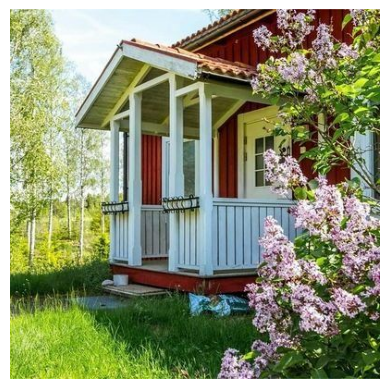


Predictions vs True Labels:
T-F - Predicted: F, True: F
E-I - Predicted: I, True: E
N-S - Predicted: S, True: S
J-P - Predicted: P, True: P

Sample Inputs:
Text: @suzuran_cc suzuranさんも近代文学を読むんですね！なんだか嬉しいです☺  ついこの前、ディケンズ「クリスマス・キャロル」を読んだのですが、あの作品も読後ホッとしました。 古い小説が好...
Numerical Features: [0.49098062889853894 1.0730939458414617 -0.2393755761472844
 0.6813588515262521 -0.9204144557000438 -1.087542840923297
 -3.548724666669227 0.3258193063854957 1.0159236973188763
 -0.12188053215487303]
Image Path: /content/drive/MyDrive/mbti-dataset/avatar/kaz_kaz_kaz777.jpg


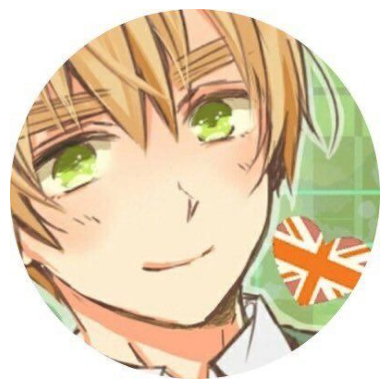


Predictions vs True Labels:
T-F - Predicted: F, True: F
E-I - Predicted: I, True: I
N-S - Predicted: S, True: S
J-P - Predicted: P, True: P

Sample Inputs:
Text: nk lapel mic drop. https://t.co/TWTlzsGawF @BettyBowers @LindseyGrahamSC @realDonaldTrump Linz is no...
Numerical Features: [-0.0722268983376828 0.12379945279996225 0.7038139427500878
 -1.1696992826193375 -0.449296125501467 -0.45975091319079897
 -0.45424060198046157 0.3422710853999818 -0.6712347805033706
 -0.12188053215487303]
Image Path: /content/drive/MyDrive/mbti-dataset/avatar/TomMitcham.jpg


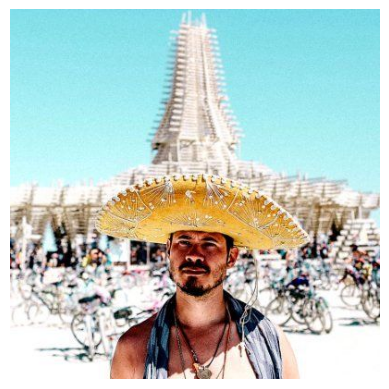


Predictions vs True Labels:
T-F - Predicted: T, True: T
E-I - Predicted: I, True: I
N-S - Predicted: S, True: S
J-P - Predicted: J, True: J

Sample Inputs:
Text: ps://t.co/xlsEEpY49d RT @angryasianman: I do not know. https://t.co/0RvP1ZjfRQ RT @Three_Cone: “Gran...
Numerical Features: [0.23012071624137642 0.5437247890867115 0.3106518014050188
 0.7840938801387068 0.7767118720126662 1.2528155276803448
 -0.09674923852190533 0.6705447746439807 -0.05821689703798279
 -0.12188053215487303]
Image Path: /content/drive/MyDrive/mbti-dataset/avatar/MidClassRepub.jpg


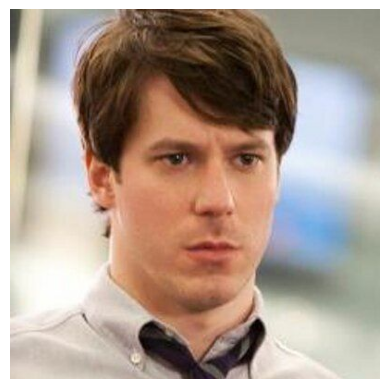


Predictions vs True Labels:
T-F - Predicted: F, True: F
E-I - Predicted: E, True: E
N-S - Predicted: N, True: N
J-P - Predicted: P, True: P

Sample Inputs:
Text: na be our year   *3 months later* https://t.co/M73neen4bp RT @mattdpearce: what a year this last hal...
Numerical Features: [-1.1295441888248698 0.4103422749772882 -0.610199623106396
 0.11884841921191962 0.25464993182680495 1.2528155276803448
 1.2559526218733341 1.089662387108446 -0.8375428957937548
 -0.12188053215487303]
Image Path: /content/drive/MyDrive/mbti-dataset/avatar/jacqgarrett.jpg


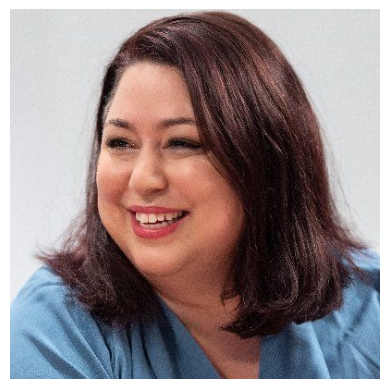


Predictions vs True Labels:
T-F - Predicted: F, True: F
E-I - Predicted: I, True: I
N-S - Predicted: S, True: S
J-P - Predicted: P, True: P


In [42]:
import torch
from transformers import BertTokenizer
from PIL import Image
import matplotlib.pyplot as plt
from torchvision import models

# Load the tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

# Function to load a trained model
def load_multimodal_model(label, model_path, num_numerical_features):
    text_model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=2)
    model = MultiModalModel(text_model=text_model, num_numerical_features=num_numerical_features)
    model.load_state_dict(torch.load(model_path, map_location=torch.device('cpu')))
    model.eval()
    return model

# Load all trained models
my_models = {}
for label in ['T-F', 'E-I', 'N-S', 'J-P']:
    model_path = f"/content/final_models/multimodal_{label}.pt"
    my_models[label] = load_multimodal_model(label, model_path, len(numerical_features))

# Function to process a single sample
def process_sample(data_row):
    # Process text
    combined_text = data_row['combined_texts']
    text_encodings = tokenizer(combined_text, truncation=True, padding=True, max_length=128, return_tensors="pt")

    # Process numerical features
    numerical_data = pd.to_numeric(data_row[numerical_features], errors='coerce').fillna(0)  # Ensure numerical values
    numerical = torch.tensor(numerical_data.values, dtype=torch.float32).unsqueeze(0)

    # Process image
    screen_name = data_row['screen_name']
    image_path = os.path.join(image_folder, f"{screen_name}.jpg")
    if os.path.exists(image_path):
        image = Image.open(image_path).convert("RGB")
        image = transform(image).unsqueeze(0)  # Apply transformations and add batch dimension
    else:
        image = torch.zeros(1, 3, *image_size)  # Placeholder for missing image

    return text_encodings, numerical, image

# Function to make predictions
def predict_labels(models, text_encodings, numerical, image):
    predictions = {}
    for label, model in my_models.items():
        with torch.no_grad():
            outputs = model(text_encodings, numerical, image)
            predicted_label = torch.argmax(outputs, dim=1).item()
            predictions[label] = predicted_label
    return predictions

# Select random samples for testing
sample_indices = data.sample(5).index  # Take 5 random samples
for idx in sample_indices:
    sample = data.iloc[idx]

    print("\nSample Inputs:")
    print(f"Text: {sample['combined_texts'][300:400]}...")  # Print first 200 characters of text
    print(f"Numerical Features: {sample[numerical_features].values}")
    screen_name = sample['screen_name']
    image_path = os.path.join(image_folder, f"{screen_name}.jpg")

    if os.path.exists(image_path):
        print(f"Image Path: {image_path}")
        image = Image.open(image_path)
        plt.imshow(image)
        plt.axis('off')
        plt.show()
    else:
        print(f"Image Missing for Screen Name: {screen_name}")

    # Process inputs
    text_encodings, numerical, image = process_sample(sample)

    # Predict labels
    predictions = predict_labels(models, text_encodings, numerical, image)

    # Get true labels
    true_labels = {
        "T-F": "T" if sample['t_f_label'] == 1 else "F",
        "E-I": "E" if sample['e_i_label'] == 1 else "I",
        "N-S": "N" if sample['n_s_label'] == 1 else "S",
        "J-P": "J" if sample['j_p_label'] == 1 else "P",
    }

    # Mapping predictions to correct labels
    predicted_labels = {
        "T-F": "T" if predictions["T-F"] == 1 else "F",
        "E-I": "E" if predictions["E-I"] == 1 else "I",
        "N-S": "N" if predictions["N-S"] == 1 else "S",
        "J-P": "J" if predictions["J-P"] == 1 else "P",
    }

    print("\nPredictions vs True Labels:")
    for label in ["T-F", "E-I", "N-S", "J-P"]:
        print(f"{label} - Predicted: {predicted_labels[label]}, True: {true_labels[label]}")
